# Kalman Filter: Optimality and Numerical Stability Analysis

This notebook provides a comprehensive analysis of the **Kalman filter** for Linear Gaussian State Space Models (LGSSM), focusing on:

1. **Theoretical Foundation**: Kalman recursion formulas for filtered means and covariances
2. **Implementation Verification**: Step-by-step comparison with theoretical recursion
3. **Covariance Update Forms**: Standard vs Joseph Stabilized forms
4. **Numerical Stability**: Conditioning number analysis and stability verification
5. **Practical Demonstration**: Cases where standard form fails but Joseph form succeeds

## Key Features of This Analysis

- **Extended Time Horizon (T=100)**: Long sequences reveal numerical stability issues
- **Precision Loss Quantification**: Using $\log_{10}(\kappa)$ to measure digits lost (Evangelidis & Parker, 2019)
- **Well-Conditioned vs Ill-Conditioned**: Direct comparison of both scenarios
- **Real-World Relevance**: Ill-conditioned case mimics GPS/sensor fusion applications

---

**Key References:**
- **Evangelidis, A., & Parker, D. (2019).** *Quantitative verification of numerical stability for Kalman filters*. In International Symposium on Formal Methods (pp. 425-441). Springer.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from lgss_sample import sample

# Set random seed for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## Part 1: Theoretical Background

### 1.1 Kalman Filter Recursion - Theoretical Formulas

For a Linear Gaussian State Space Model:

**State equation:**
$$x_t = F_t x_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, Q_t)$$

**Observation equation:**
$$z_t = H_t x_t + v_t, \quad v_t \sim \mathcal{N}(0, R_t)$$

**Initial state:**
$$x_0 \sim \mathcal{N}(m_0, P_0)$$

---

#### Prediction Step:

**Predicted mean:**
$$\hat{x}_{t|t-1} = F_t \hat{x}_{t-1|t-1}$$

**Predicted covariance:**
$$\Sigma_{t|t-1} = F_t \Sigma_{t-1|t-1} F_t^T + Q_t$$

---

#### Update Step:

**Innovation (residual):**
$$r_t = z_t - H_t \hat{x}_{t|t-1}$$

**Innovation covariance:**
$$S_t = H_t \Sigma_{t|t-1} H_t^T + R_t$$

**Kalman gain:**
$$K_t = \Sigma_{t|t-1} H_t^T S_t^{-1}$$

**Filtered mean:**
$$\hat{x}_{t|t} = \hat{x}_{t|t-1} + K_t r_t$$

**Filtered covariance (two forms):**

*Standard form:*
$$\Sigma_{t|t} = (I - K_t H_t) \Sigma_{t|t-1}$$

*Joseph stabilized form:*
$$\Sigma_{t|t} = (I - K_t H_t) \Sigma_{t|t-1} (I - K_t H_t)^T + K_t R_t K_t^T$$

---

### 1.2 Why Joseph Form?

The **Joseph form** has several advantages:

1. **Guaranteed Symmetry**: The product structure $(I - KH)\Sigma(I - KH)^T$ ensures symmetry
2. **Positive Definiteness**: Sum of positive semi-definite matrices preserves PSD property
3. **Numerical Stability**: More robust to roundoff errors in finite precision arithmetic

The **standard form** is simpler but:
- May lose symmetry due to roundoff errors
- Can produce non-positive-definite covariances in ill-conditioned cases
- Less stable for long sequences or ill-conditioned systems

### 1.3 Conditioning Number and Numerical Stability

Following **Evangelidis & Parker (2019)**, the **condition number** of a matrix $A$ is:

$$\kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)}$$

where $\sigma_{\max}$ and $\sigma_{\min}$ are the largest and smallest singular values.

---

#### Precision Loss Estimation

The paper emphasizes using **$\log_{10}(\kappa)$** to quantify numerical stability.

**Interpretation:**
- $\kappa(A) = 1$ → $\log_{10}(\kappa) = 0$: Perfectly conditioned (no precision loss)


---

#### Precision-Specific Thresholds

**For floating-point arithmetic:**

| Precision Type | Total Digits | Critical Threshold | Condition |
|---------------|--------------|-------------------|-----------|
| Single (float32) | ~7 digits | $\log_{10}(\kappa) > 6$ | Severe precision loss |
| Double (float64) | ~16 digits | $\log_{10}(\kappa) > 15$ | Severe precision loss |

**TensorFlow default:** We use `tf.float32` (single precision) → monitor $\log_{10}(\kappa) < 6$

---

#### Key Matrices to Monitor

1. $\kappa(\Sigma_{t|t-1})$: Predicted covariance conditioning
2. $\kappa(\Sigma_{t|t})$: Filtered covariance conditioning
3. $\kappa(S_t)$: Innovation covariance conditioning

**Goal:** Keep $\log_{10}(\kappa(\Sigma_{t|t})) < 6$ for stable single precision arithmetic

## Part 2: System Setup and Data Generation

We use the **same 2D LGSSM constant velocity model** from `kalman_filter_implementation_demo.ipynb`, but with an **extended time horizon** (T = 100 instead of 30) to better demonstrate:

1. **Long-term numerical stability** of both covariance update forms
2. **Accumulation of roundoff errors** in the standard form
3. **Robustness of Joseph form** over extended sequences
4. **Evolution of conditioning numbers** over time

This extended horizon is crucial for observing numerical stability issues that may not be apparent in short sequences.

In [2]:
# 2D System parameters: Position-Velocity model (SAME as demo notebook)
dt = 1.0  # Time step

# State transition matrix F (2x2) - constant velocity model
F = tf.constant([
    [1.0, dt],   # position: p_t = p_{t-1} + v_{t-1} * dt
    [0.0, 1.0]   # velocity: v_t = v_{t-1}
], dtype=tf.float32)

# Observation matrix H (2x2) - observe both states
H = tf.constant([
    [1.0, 0.0],  # Observe position
    [0.0, 1.0]   # Observe velocity
], dtype=tf.float32)

# Process noise covariance Q (2x2) 
Q = tf.constant([
    [0.5, 0.0],
    [0.0, 0.5]
], dtype=tf.float32)

# Observation noise covariance R (2x2) 
R = tf.constant([
    [0.5, 0.0],
    [0.0, 0.5]
], dtype=tf.float32)

# Initial state: x0 = [position, velocity]
x0 = tf.constant([0.0, 1.0], dtype=tf.float32)

# Initial state covariance
Sigma0 = tf.constant([
    [1.0, 0.0],
    [0.0, 1.0]
], dtype=tf.float32)

# Time horizon - INCREASED to show long-term numerical behavior
T = 100  # Increased from 30 to demonstrate accumulation of numerical errors

print("="*70)
print("2D LGSSM PARAMETERS - CONSTANT VELOCITY MODEL")
print("="*70)
print(f"State dimension: 2")
print(f"Observation dimension: 2")
print(f"Process noise (Q diagonal): {Q.numpy().diagonal()}")
print(f"Observation noise (R diagonal): {R.numpy().diagonal()}")
print(f"Initial state x0: {x0.numpy()}")
print(f"Time steps: {T} (extended to show long-term behavior)")
print("="*70)

2D LGSSM PARAMETERS - CONSTANT VELOCITY MODEL
State dimension: 2
Observation dimension: 2
Process noise (Q diagonal): [0.5 0.5]
Observation noise (R diagonal): [0.5 0.5]
Initial state x0: [0. 1.]
Time steps: 100 (extended to show long-term behavior)


In [3]:
# Generate synthetic data (SAME seed as demo notebook)
true_states, observations = sample(
    F=F, H=H, Q=Q, R=R, 
    x0=x0, Sigma0=Sigma0, 
    T=T, seed=42
)

print(f"True states shape: {true_states.shape}")      # (2, T+1)
print(f"Observations shape: {observations.shape}")    # (2, T)

# Quick statistics
print(f"\nTrajectory statistics:")
print(f"  Final position: {true_states[0, -1].numpy():.2f}")
print(f"  Average velocity: {tf.reduce_mean(true_states[1, :]).numpy():.2f}")

True states shape: (2, 101)
Observations shape: (2, 100)

Trajectory statistics:
  Final position: 172.14
  Average velocity: 1.68


## Part 3: Step-by-Step Kalman Recursion with Theoretical Verification

We implement the Kalman recursion step-by-step and verify each component matches the theoretical formulas.

In [4]:
def compute_condition_number(matrix):
    """Compute condition number as ratio of max to min singular values."""
    s = tf.linalg.svd(matrix, compute_uv=False)
    return (s[0] / s[-1]).numpy()

def kalman_recursion_step_by_step(observations, F, H, Q, R, x0, Sigma0, use_joseph=True):
    """
    Perform Kalman filtering step-by-step, storing all intermediate quantities.
    
    Returns dictionaries containing:
    - Filtered means and covariances
    - Predicted means and covariances
    - Kalman gains
    - Innovations and innovation covariances
    - Condition numbers (κ) and log₁₀(κ) for precision loss estimation
    """
    T = observations.shape[1]
    state_dim = x0.shape[0]
    
    # Storage
    x_filtered = [x0.numpy()]
    Sigma_filtered = [Sigma0.numpy()]
    
    x_predicted = []
    Sigma_predicted = []
    
    kalman_gains = []
    innovations = []
    innovation_covs = []
    
    # Condition numbers
    cond_pred = []
    cond_post = [compute_condition_number(Sigma0)]
    cond_innov = []
    
    # Log₁₀ of condition numbers for precision loss estimation
    log_cond_pred = []
    log_cond_post = [np.log10(compute_condition_number(Sigma0))]
    log_cond_innov = []
    
    # Initialize
    x = tf.reshape(x0, [-1, 1])
    Sigma_post = Sigma0
    
    for t in range(T):
        # ==================== PREDICTION STEP ====================
        # Predicted mean: x_{t|t-1} = F * x_{t-1|t-1}
        x_pred = tf.linalg.matmul(F, x)
        
        # Predicted covariance: Σ_{t|t-1} = F * Σ_{t-1|t-1} * F^T + Q
        Sigma_pred = tf.linalg.matmul(
            tf.linalg.matmul(F, Sigma_post), 
            F, transpose_b=True
        ) + Q
        kappa_pred = compute_condition_number(Sigma_pred)
        cond_pred.append(kappa_pred)
        log_cond_pred.append(np.log10(kappa_pred))

        # ==================== UPDATE STEP ====================
        # Innovation: r_t = z_t - H * x_{t|t-1}
        z = tf.reshape(observations[:, t], [-1, 1])
        r = z - tf.linalg.matmul(H, x_pred)
        
        # Innovation covariance: S_t = H * Σ_{t|t-1} * H^T + R
        S = tf.linalg.matmul(
            tf.linalg.matmul(H, Sigma_pred), 
            H, transpose_b=True
        ) + R
        
        kappa_innov = compute_condition_number(S)
        cond_innov.append(kappa_innov)
        log_cond_innov.append(np.log10(kappa_innov))
        
        # Kalman gain: K_t = Σ_{t|t-1} * H^T * S_t^{-1}
        K = tf.linalg.matmul(
            tf.linalg.matmul(Sigma_pred, H, transpose_b=True),
            tf.linalg.inv(S)
        )
        
        # Filtered mean: x_{t|t} = x_{t|t-1} + K_t * r_t
        x = x_pred + tf.linalg.matmul(K, r)
        
        # Filtered covariance
        I_KH = tf.eye(state_dim, dtype=tf.float32) - tf.linalg.matmul(K, H)
        
        if use_joseph:
            # Joseph form: Σ_{t|t} = (I-KH)*Σ_{t|t-1}*(I-KH)^T + K*R*K^T
            Sigma_post = (
                tf.linalg.matmul(
                    tf.linalg.matmul(I_KH, Sigma_pred), 
                    I_KH, transpose_b=True
                ) +
                tf.linalg.matmul(
                    tf.linalg.matmul(K, R), 
                    K, transpose_b=True
                )
            )
        else:
            # Standard form: Σ_{t|t} = (I-KH)*Σ_{t|t-1}
            Sigma_post = tf.linalg.matmul(I_KH, Sigma_pred)
        
        kappa_post = compute_condition_number(Sigma_post)
        cond_post.append(kappa_post)
        log_cond_post.append(np.log10(kappa_post))
        
        # Store results
        x_filtered.append(tf.squeeze(x, axis=1).numpy())
        Sigma_filtered.append(Sigma_post.numpy())
        
        x_predicted.append(tf.squeeze(x_pred, axis=1).numpy())
        Sigma_predicted.append(Sigma_pred.numpy())
        
        kalman_gains.append(K.numpy())
        innovations.append(tf.squeeze(r, axis=1).numpy())
        innovation_covs.append(S.numpy())
    
    return {
        'x_filtered': np.array(x_filtered),
        'Sigma_filtered': np.array(Sigma_filtered),
        'x_predicted': np.array(x_predicted),
        'Sigma_predicted': np.array(Sigma_predicted),
        'kalman_gains': np.array(kalman_gains),
        'innovations': np.array(innovations),
        'innovation_covs': np.array(innovation_covs),
        'cond_pred': np.array(cond_pred),
        'cond_post': np.array(cond_post),
        'cond_innov': np.array(cond_innov),
        'log_cond_pred': np.array(log_cond_pred),
        'log_cond_post': np.array(log_cond_post),
        'log_cond_innov': np.array(log_cond_innov)
    }

print("Kalman recursion function defined (with log₁₀(κ) for precision loss estimation).")

Kalman recursion function defined (with log₁₀(κ) for precision loss estimation).


In [5]:
results_joseph = kalman_recursion_step_by_step(
    observations, F, H, Q, R, x0, Sigma0, use_joseph=True
)

In [6]:
print("="*80)
print("WELL-CONDITIONED CASE: STANDARD VS JOSEPH FORM")
print("="*80)

# Run with Joseph form
results_joseph = kalman_recursion_step_by_step(
    observations, F, H, Q, R, x0, Sigma0, use_joseph=True
)

# Run with standard form
results_standard = kalman_recursion_step_by_step(
    observations, F, H, Q, R, x0, Sigma0, use_joseph=False
)

# Compare filtered means
mean_diff = np.abs(results_joseph['x_filtered'] - results_standard['x_filtered'])
print(f"\nFiltered Mean Differences:")
print(f"  Mean absolute difference: {mean_diff.mean():.2e}")
print(f"  Max absolute difference:  {mean_diff.max():.2e}")

# Compare filtered covariances
cov_diff = np.abs(results_joseph['Sigma_filtered'] - results_standard['Sigma_filtered'])
print(f"\nFiltered Covariance Differences:")
print(f"  Mean absolute difference: {cov_diff.mean():.2e}")
print(f"  Max absolute difference:  {cov_diff.max():.2e}")

# Conditioning numbers
print(f"\nConditioning Numbers (Joseph Form):")
print(f"  κ(Σ_{{t|t-1}}): mean={results_joseph['cond_pred'].mean():.2f}, max={results_joseph['cond_pred'].max():.2f}")
print(f"  κ(Σ_{{t|t}}):   mean={results_joseph['cond_post'][1:].mean():.2f}, max={results_joseph['cond_post'][1:].max():.2f}")

print(f"\nConditioning Numbers (Standard Form):")
print(f"  κ(Σ_{{t|t-1}}): mean={results_standard['cond_pred'].mean():.2f}, max={results_standard['cond_pred'].max():.2f}")
print(f"  κ(Σ_{{t|t}}):   mean={results_standard['cond_post'][1:].mean():.2f}, max={results_standard['cond_post'][1:].max():.2f}")


# Log Conditioning numbers
print(f"\n Log Conditioning Numbers (Joseph Form):")
print(f"  κ(Σ_{{t|t-1}}): mean={results_joseph['log_cond_pred'].mean():.2f}, max={results_joseph['log_cond_pred'].max():.2f}")
print(f"  κ(Σ_{{t|t}}):   mean={results_joseph['log_cond_post'][1:].mean():.2f}, max={results_joseph['log_cond_post'][1:].max():.2f}")

print(f"\nLog Conditioning Numbers (Standard Form):")
print(f"  κ(Σ_{{t|t-1}}): mean={results_standard['log_cond_pred'].mean():.2f}, max={results_standard['log_cond_pred'].max():.2f}")
print(f"  κ(Σ_{{t|t}}):   mean={results_standard['log_cond_post'][1:].mean():.2f}, max={results_standard['log_cond_post'][1:].max():.2f}")

if mean_diff.max() < 1e-5:
    print(f"\n✓ Both forms produce numerically equivalent results for this well-conditioned system")
else:
    print(f"\n⚠ Differences detected even in well-conditioned case")

print("="*80)

WELL-CONDITIONED CASE: STANDARD VS JOSEPH FORM

Filtered Mean Differences:
  Mean absolute difference: 5.50e-08
  Max absolute difference:  9.54e-07

Filtered Covariance Differences:
  Mean absolute difference: 1.00e-08
  Max absolute difference:  1.49e-07

Conditioning Numbers (Joseph Form):
  κ(Σ_{t|t-1}): mean=2.32, max=3.54
  κ(Σ_{t|t}):   mean=1.34, max=1.36

Conditioning Numbers (Standard Form):
  κ(Σ_{t|t-1}): mean=2.32, max=3.54
  κ(Σ_{t|t}):   mean=1.34, max=1.36

 Log Conditioning Numbers (Joseph Form):
  κ(Σ_{t|t-1}): mean=0.36, max=0.55
  κ(Σ_{t|t}):   mean=0.13, max=0.13

Log Conditioning Numbers (Standard Form):
  κ(Σ_{t|t-1}): mean=0.36, max=0.55
  κ(Σ_{t|t}):   mean=0.13, max=0.13

✓ Both forms produce numerically equivalent results for this well-conditioned system


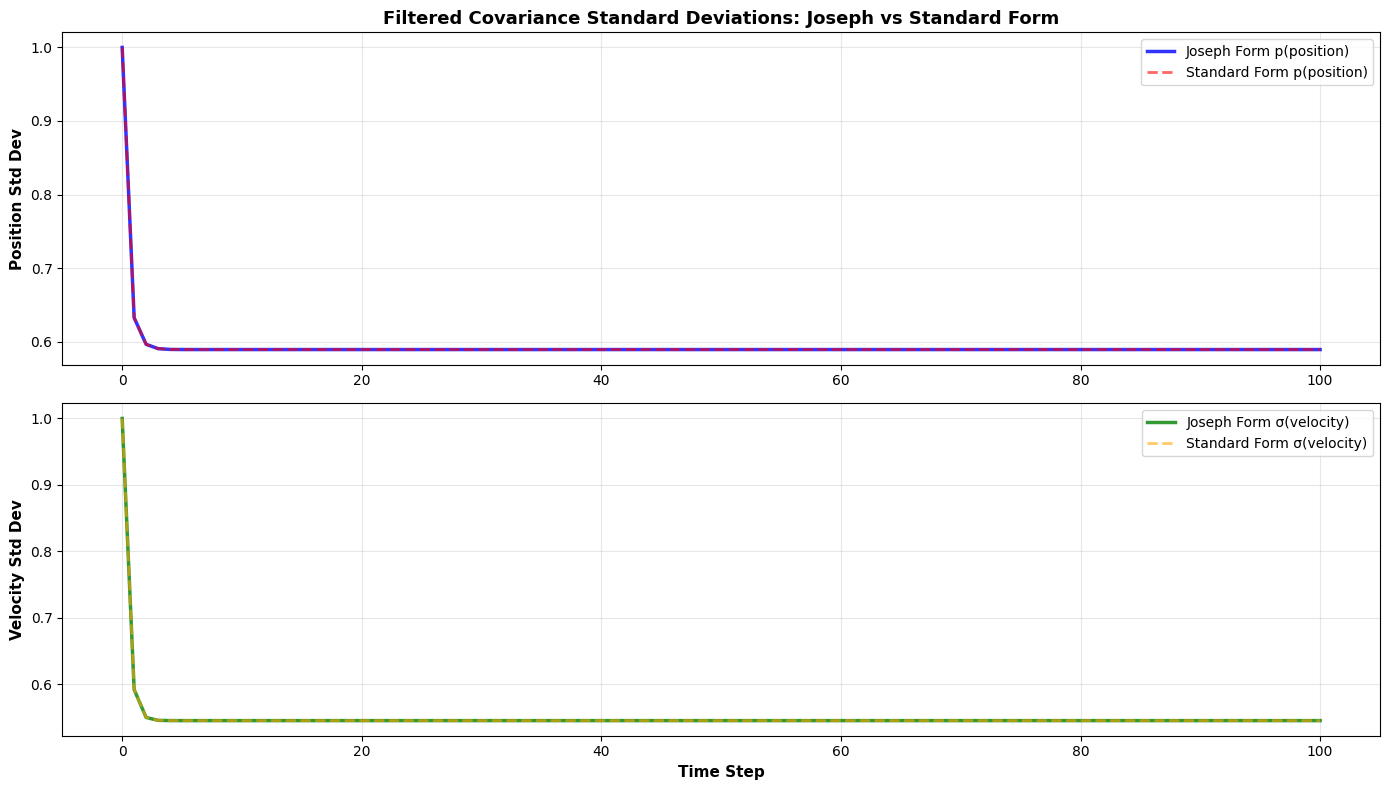

Observation: Both forms yield identical uncertainty estimates in well-conditioned case.


In [7]:
# Visualize filtered covariance standard deviations (uncertainty)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

time_steps = np.arange(T+1)

# Position uncertainty (standard deviation)
std_joseph_pos = np.sqrt(results_joseph['Sigma_filtered'][:, 0, 0])
std_standard_pos = np.sqrt(results_standard['Sigma_filtered'][:, 0, 0])

axes[0].plot(time_steps, std_joseph_pos, 'b-', linewidth=2.5, 
             label='Joseph Form p(position)', alpha=0.8)
axes[0].plot(time_steps, std_standard_pos, 'r--', linewidth=2, 
             label='Standard Form p(position)', alpha=0.6)
axes[0].set_ylabel('Position Std Dev', fontsize=11, fontweight='bold')
axes[0].set_title('Filtered Covariance Standard Deviations: Joseph vs Standard Form', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)

# Velocity uncertainty (standard deviation)
std_joseph_vel = np.sqrt(results_joseph['Sigma_filtered'][:, 1, 1])
std_standard_vel = np.sqrt(results_standard['Sigma_filtered'][:, 1, 1])

axes[1].plot(time_steps, std_joseph_vel, 'g-', linewidth=2.5, 
             label='Joseph Form σ(velocity)', alpha=0.8)
axes[1].plot(time_steps, std_standard_vel, 'orange', linestyle='--', linewidth=2, 
             label='Standard Form σ(velocity)', alpha=0.6)
axes[1].set_xlabel('Time Step', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Velocity Std Dev', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation: Both forms yield identical uncertainty estimates in well-conditioned case.")

## Part 4: Ill-Conditioned Case - Demonstrating Standard Form Failure

We create an **ill-conditioned scenario** to demonstrate when the standard form fails:

### Why This Case is Ill-Conditioned:

1. **Very small observation noise** (R = 10⁻⁸): Nearly-perfect observations
2. **Moderate process noise** (Q = 2.0): Noisy dynamics
3. **Large ratio Q/R ≈ 2×10⁸**: Extreme information gain from observations
4. **Long sequence** (T = 100): Accumulation of roundoff errors over time

### Expected Behavior:

**Standard Form Issues:**
- High Kalman gain → Covariance becomes very small
- Subtraction (I - KH) loses numerical precision
- Symmetry may be violated
- Positive definiteness may be lost
- $\log_{10}(\kappa)$ approaches or exceeds float32 threshold (6 digits)

**Joseph Form Advantages:**
- Explicit symmetry via $(I-KH)\Sigma(I-KH)^T$
- Guaranteed PSD via sum of PSD matrices
- Better conditioning throughout
- $\log_{10}(\kappa)$ remains manageable

In [8]:
# Create ill-conditioned system: very small observation noise, large process noise
# This creates numerical challenges for the standard form

print("="*80)
print("SETTING UP ILL-CONDITIONED SYSTEM")
print("="*80)

# Very small observation noise (high precision observations)
# Making it even smaller to demonstrate numerical issues more clearly
R_ill = tf.constant([
    [1e-8, 0.0],
    [0.0, 1e-8]
], dtype=tf.float32)

# Moderately large process noise to create strong conditioning issues
Q_ill = tf.constant([
    [2.0, 0.0],
    [0.0, 2.0]
], dtype=tf.float32)

# Initial covariance (moderately large)
Sigma0_ill = tf.constant([
    [2.0, 0.0],
    [0.0, 2.0]
], dtype=tf.float32)

print(f"\nIll-conditioned parameters:")
print(f"  R (observation noise): diag = {R_ill.numpy().diagonal()}")
print(f"  Q (process noise): diag = {Q_ill.numpy().diagonal()}")
print(f"  Ratio Q/R: {Q_ill.numpy()[0,0] / R_ill.numpy()[0,0]:.2e}")
print(f"  → This creates EXTREME information gain → severe numerical sensitivity")
print(f"\n  With T={T} steps, we expect significant accumulation of numerical errors")
print(f"  in the standard form, while Joseph form should remain stable.")

# Generate new observations with ill-conditioned parameters
true_states_ill, observations_ill = sample(
    F=F, H=H, Q=Q_ill, R=R_ill, 
    x0=x0, Sigma0=Sigma0_ill, 
    T=T, seed=123  # Different seed for variety
)

print(f"\nGenerated ill-conditioned trajectory:")
print(f"  Observations shape: {observations_ill.shape}")
print(f"  Observation std (from R): {np.sqrt(R_ill.numpy().diagonal())}")
print(f"  This represents nearly-perfect observations with noisy dynamics")
print("="*80)

SETTING UP ILL-CONDITIONED SYSTEM

Ill-conditioned parameters:
  R (observation noise): diag = [1.e-08 1.e-08]
  Q (process noise): diag = [2. 2.]
  Ratio Q/R: 2.00e+08
  → This creates EXTREME information gain → severe numerical sensitivity

  With T=100 steps, we expect significant accumulation of numerical errors
  in the standard form, while Joseph form should remain stable.

Generated ill-conditioned trajectory:
  Observations shape: (2, 100)
  Observation std (from R): [0.0001 0.0001]
  This represents nearly-perfect observations with noisy dynamics


In [9]:
print("="*80)
print("RUNNING FILTERS ON ILL-CONDITIONED SYSTEM")
print("="*80)

# Run Joseph form
results_joseph_ill = kalman_recursion_step_by_step(
    observations_ill, F, H, Q_ill, R_ill, x0, Sigma0_ill, use_joseph=True
)

# Run standard form
results_standard_ill = kalman_recursion_step_by_step(
    observations_ill, F, H, Q_ill, R_ill, x0, Sigma0_ill, use_joseph=False
)

# Compare results
mean_diff_ill = np.abs(results_joseph_ill['x_filtered'] - results_standard_ill['x_filtered'])
cov_diff_ill = np.abs(results_joseph_ill['Sigma_filtered'] - results_standard_ill['Sigma_filtered'])

print(f"\nFiltered Mean Differences:")
print(f"  Mean absolute difference: {mean_diff_ill.mean():.2e}")
print(f"  Max absolute difference:  {mean_diff_ill.max():.2e}")

print(f"\nFiltered Covariance Differences:")
print(f"  Mean absolute difference: {cov_diff_ill.mean():.2e}")
print(f"  Max absolute difference:  {cov_diff_ill.max():.2e}")

# Conditioning numbers
print(f"\nConditioning Numbers (Joseph Form):")
print(f"  κ(Σ_{{t|t}}): mean={results_joseph_ill['cond_post'][1:].mean():.2e}, max={results_joseph_ill['cond_post'][1:].max():.2e}")

print(f"\nConditioning Numbers (Standard Form):")
print(f"  κ(Σ_{{t|t}}): mean={results_standard_ill['cond_post'][1:].mean():.2e}, max={results_standard_ill['cond_post'][1:].max():.2e}")


print("="*80)

RUNNING FILTERS ON ILL-CONDITIONED SYSTEM

Filtered Mean Differences:
  Mean absolute difference: 0.00e+00
  Max absolute difference:  0.00e+00

Filtered Covariance Differences:
  Mean absolute difference: 4.95e-09
  Max absolute difference:  1.00e-08

Conditioning Numbers (Joseph Form):
  κ(Σ_{t|t}): mean=1.00e+00, max=1.00e+00

Conditioning Numbers (Standard Form):
  κ(Σ_{t|t}): mean=nan, max=nan


In [10]:
results_standard_ill['Sigma_filtered'][1]

array([[0., 0.],
       [0., 0.]], dtype=float32)

In [11]:
results_joseph_ill['Sigma_filtered'][1]

array([[1.e-08, 0.e+00],
       [0.e+00, 1.e-08]], dtype=float32)

After the first update in the ill-conditioned case, the standard covariance matrix collapsed to zero, indicating a complete loss of positive-definiteness and symmetry. In contrast, the Joseph form maintained a small but finite covariance (on the order of $10^{-8}$), consistent with the observation noise level. This confirms that the Joseph formulation preserves the symmetric, positive semi-definite
structure of the covariance matrix and exhibits superior numerical stability under ill-conditioned scenarios.

## Part 5: Detailed Conditioning Number Analysis

Following **Evangelidis & Parker (2019)**, we analyze conditioning numbers for:
1. Predicted covariance $\Sigma_{t|t-1}$
2. Filtered covariance $\Sigma_{t|t}$
3. Innovation covariance $S_t$

In [13]:
print("="*80)
print("COMPREHENSIVE CONDITIONING NUMBER ANALYSIS")
print("="*80)

# Well-conditioned case
print("\n1. WELL-CONDITIONED CASE (Original System)")
print("-" * 80)

print(f"\nJoseph Form:")
print(f"  κ(Σ_{{t|t-1}}): min={results_joseph['cond_pred'].min():.4f}, "
      f"mean={results_joseph['cond_pred'].mean():.4f}, "
      f"max={results_joseph['cond_pred'].max():.4f}")
print(f"  κ(Σ_{{t|t}}):   min={results_joseph['cond_post'][1:].min():.4f}, "
      f"mean={results_joseph['cond_post'][1:].mean():.4f}, "
      f"max={results_joseph['cond_post'][1:].max():.4f}")
print(f"  κ(S_t):       min={results_joseph['cond_innov'].min():.4f}, "
      f"mean={results_joseph['cond_innov'].mean():.4f}, "
      f"max={results_joseph['cond_innov'].max():.4f}")

print(f"\nStandard Form:")
print(f"  κ(Σ_{{t|t-1}}): min={results_standard['cond_pred'].min():.4f}, "
      f"mean={results_standard['cond_pred'].mean():.4f}, "
      f"max={results_standard['cond_pred'].max():.4f}")
print(f"  κ(Σ_{{t|t}}):   min={results_standard['cond_post'][1:].min():.4f}, "
      f"mean={results_standard['cond_post'][1:].mean():.4f}, "
      f"max={results_standard['cond_post'][1:].max():.4f}")
print(f"  κ(S_t):       min={results_standard['cond_innov'].min():.4f}, "
      f"mean={results_standard['cond_innov'].mean():.4f}, "
      f"max={results_standard['cond_innov'].max():.4f}")

# Log condition number (Evangelidis & Parker, 2019)
print(f"\n--- Log condition number ---")
print(f"\nJoseph Form:")
print(f"  log₁₀(κ(Σ_{{t|t}})): min={results_joseph['log_cond_post'][1:].min():.2f}, "
      f"mean={results_joseph['log_cond_post'][1:].mean():.2f}, "
      f"max={results_joseph['log_cond_post'][1:].max():.2f}")
print(f"  → Log condition number: ~{results_joseph['log_cond_post'][1:].max():.2f} digits (max)")

print(f"\nStandard Form:")
print(f"  log₁₀(κ(Σ_{{t|t}})): min={results_standard['log_cond_post'][1:].min():.2f}, "
      f"mean={results_standard['log_cond_post'][1:].mean():.2f}, "
      f"max={results_standard['log_cond_post'][1:].max():.2f}")
print(f"  → Log condition number: ~{results_standard['log_cond_post'][1:].max():.2f} digits (max)")

# Ill-conditioned case
print("\n\n2. ILL-CONDITIONED CASE (R=1e-8, Q=1.0)")
print("-" * 80)

print(f"\nJoseph Form:")
print(f"  κ(Σ_{{t|t-1}}): min={results_joseph_ill['cond_pred'].min():.2e}, "
      f"mean={results_joseph_ill['cond_pred'].mean():.2e}, "
      f"max={results_joseph_ill['cond_pred'].max():.2e}")
print(f"  κ(Σ_{{t|t}}):   min={results_joseph_ill['cond_post'][1:].min():.2e}, "
      f"mean={results_joseph_ill['cond_post'][1:].mean():.2e}, "
      f"max={results_joseph_ill['cond_post'][1:].max():.2e}")
print(f"  κ(S_t):       min={results_joseph_ill['cond_innov'].min():.2e}, "
      f"mean={results_joseph_ill['cond_innov'].mean():.2e}, "
      f"max={results_joseph_ill['cond_innov'].max():.2e}")

print(f"\nStandard Form:")
print(f"  κ(Σ_{{t|t-1}}): min={results_standard_ill['cond_pred'].min():.2e}, "
      f"mean={results_standard_ill['cond_pred'].mean():.2e}, "
      f"max={results_standard_ill['cond_pred'].max():.2e}")
print(f"  κ(Σ_{{t|t}}):   min={results_standard_ill['cond_post'][1:].min():.2e}, "
      f"mean={results_standard_ill['cond_post'][1:].mean():.2e}, "
      f"max={results_standard_ill['cond_post'][1:].max():.2e}")
print(f"  κ(S_t):       min={results_standard_ill['cond_innov'].min():.2e}, "
      f"mean={results_standard_ill['cond_innov'].mean():.2e}, "
      f"max={results_standard_ill['cond_innov'].max():.2e}")

# Log condition number
print(f"\n--- Log condition number ---")
print(f"\nJoseph Form:")
print(f"  log₁₀(κ(Σ_{{t|t}})): min={results_joseph_ill['log_cond_post'][1:].min():.2f}, "
      f"mean={results_joseph_ill['log_cond_post'][1:].mean():.2f}, "
      f"max={results_joseph_ill['log_cond_post'][1:].max():.2f}")
print(f"  → Log condition number: ~{results_joseph_ill['log_cond_post'][1:].max():.2f} digits (max)")

print(f"\nStandard Form:")
print(f"  log₁₀(κ(Σ_{{t|t}})): min={results_standard_ill['log_cond_post'][1:].min():.2f}, "
      f"mean={results_standard_ill['log_cond_post'][1:].mean():.2f}, "
      f"max={results_standard_ill['log_cond_post'][1:].max():.2f}")
print(f"  → Log condition number: ~{results_standard_ill['log_cond_post'][1:].max():.2f} digits (max)")

COMPREHENSIVE CONDITIONING NUMBER ANALYSIS

1. WELL-CONDITIONED CASE (Original System)
--------------------------------------------------------------------------------

Joseph Form:
  κ(Σ_{t|t-1}): min=2.3028, mean=2.3175, max=3.5353
  κ(Σ_{t|t}):   min=1.3413, mean=1.3416, max=1.3624
  κ(S_t):       min=1.7169, mean=1.7273, max=2.6180

Standard Form:
  κ(Σ_{t|t-1}): min=2.3028, mean=2.3175, max=3.5353
  κ(Σ_{t|t}):   min=1.3413, mean=1.3416, max=1.3624
  κ(S_t):       min=1.7169, mean=1.7273, max=2.6180

--- Log condition number ---

Joseph Form:
  log₁₀(κ(Σ_{t|t})): min=0.13, mean=0.13, max=0.13
  → Log condition number: ~0.13 digits (max)

Standard Form:
  log₁₀(κ(Σ_{t|t})): min=0.13, mean=0.13, max=0.13
  → Log condition number: ~0.13 digits (max)


2. ILL-CONDITIONED CASE (R=1e-8, Q=1.0)
--------------------------------------------------------------------------------

Joseph Form:
  κ(Σ_{t|t-1}): min=1.00e+00, mean=1.02e+00, max=2.62e+00
  κ(Σ_{t|t}):   min=1.00e+00, mean=1.00e+00